<a href="https://colab.research.google.com/github/mahaqj/Machine-Learning-Assignment-1/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Robotics: Assignment 1
## By Maha Qaiser 22i-2348

In [15]:
import kagglehub
import math as mt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit

# Task 1: Data Selection & Understanding


In [16]:
# 1. choose a public dataset with at least 1 million records
path = kagglehub.dataset_download("amitanshjoshi/spotify-1million-tracks")

In [17]:
# 2. describe the dataset
print("domain of this dataset: music")
print("target variable: popularity (in percentage)")
print("number of features: 15")
print("number of records: 1001373 (1 million)")
print("type of problem: regression")

domain of this dataset: music
target variable: popularity (in percentage)
number of features: 15
number of records: 1001373 (1 million)
type of problem: regression


In [18]:
dataset = pd.read_csv(path + "/spotify_data.csv") #load the data
dataset = dataset.drop(columns=['Unnamed: 0', 'artist_name', 'track_id', 'track_name']) #remove unnecessary columns
print(dataset.head())

   popularity  year     genre  danceability  energy  key  loudness  mode  \
0          68  2012  acoustic         0.483   0.303    4   -10.058     1   
1          50  2012  acoustic         0.572   0.454    3   -10.286     1   
2          57  2012  acoustic         0.409   0.234    3   -13.711     1   
3          58  2012  acoustic         0.392   0.251   10    -9.845     1   
4          54  2012  acoustic         0.430   0.791    6    -5.419     0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0429        0.6940          0.000000    0.1150    0.139  133.406   
1       0.0258        0.4770          0.000014    0.0974    0.515  140.182   
2       0.0323        0.3380          0.000050    0.0895    0.145  139.832   
3       0.0363        0.8070          0.000000    0.0797    0.508  204.961   
4       0.0302        0.0726          0.019300    0.1100    0.217  171.864   

   duration_ms  time_signature  
0       240166               3  
1       

In [19]:
print("rows in dataset:", len(dataset))
dataset = dataset[dataset["popularity"] != 0] #around 150000 tracks have 0% popularity which will negatively impact our outputs, so remove those rows
print("remaining rows in dataset:", len(dataset))

rows in dataset: 1159764
remaining rows in dataset: 1001373


# Task 2: Exploratory Data Analysis (EDA)

In [20]:
numerical_features = dataset[['popularity', 'year', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
#categorical_features = dataset[['genre', 'key', 'mode', 'time_signature']] #just for the reader to see lol

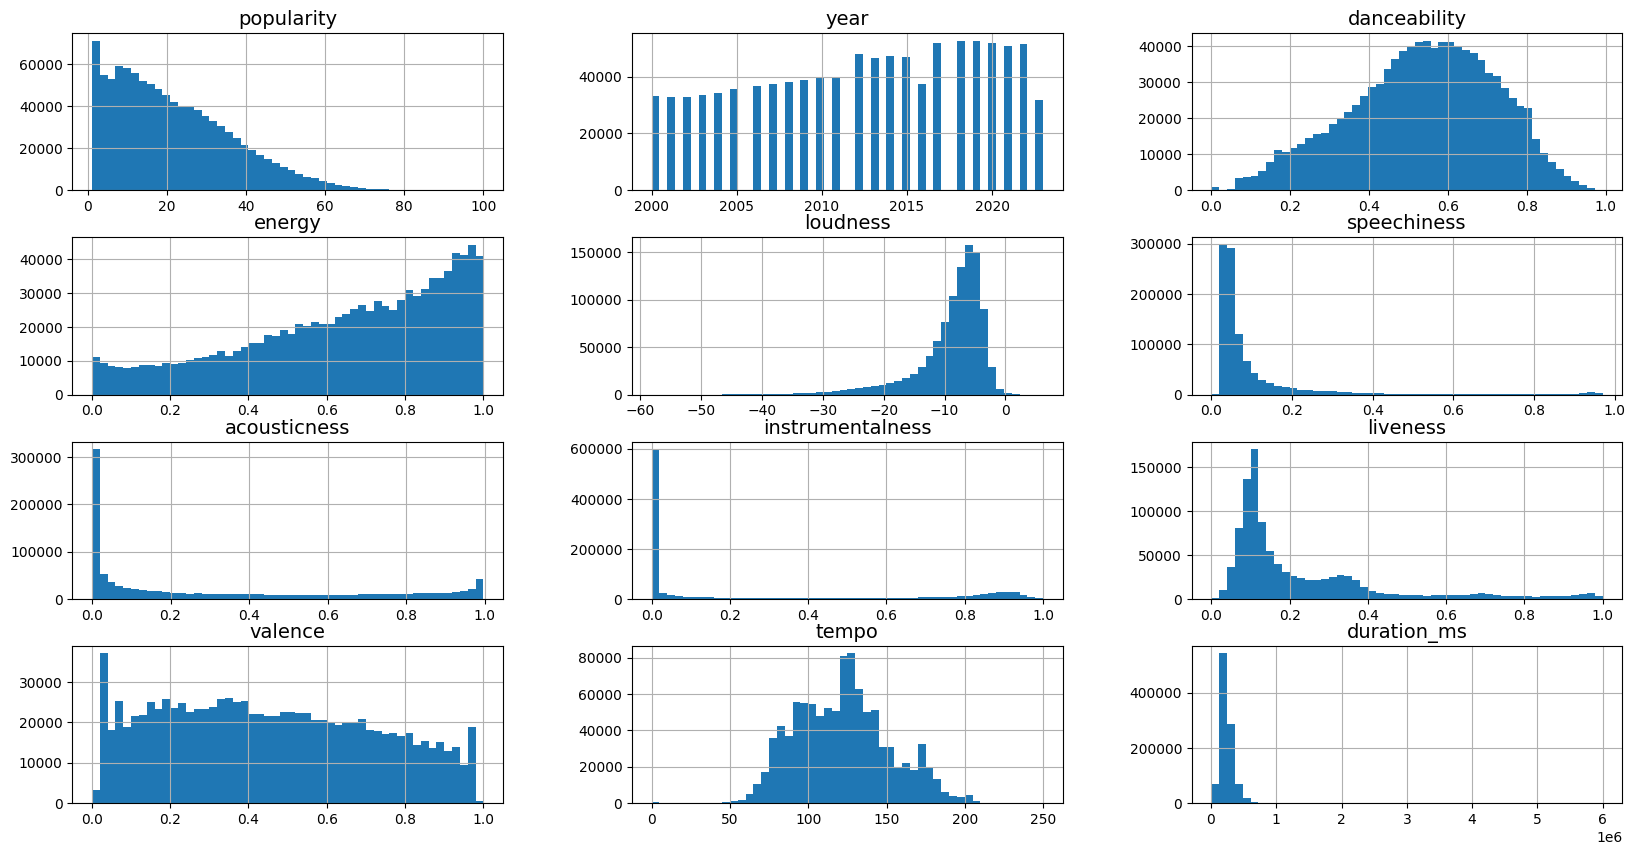

In [ ]:
# 1. perform data visualisation
## a. histograms for numeric features
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
numerical_features.hist(bins=50, figsize=(20,10))
plt.show()

correlation with popularity
popularity          1.000000
year                0.330474
danceability        0.128300
loudness            0.089483
tempo               0.000062
valence            -0.004357
energy             -0.005227
speechiness        -0.035673
acousticness       -0.048313
liveness           -0.076398
duration_ms        -0.118347
instrumentalness   -0.143145
Name: popularity, dtype: float64


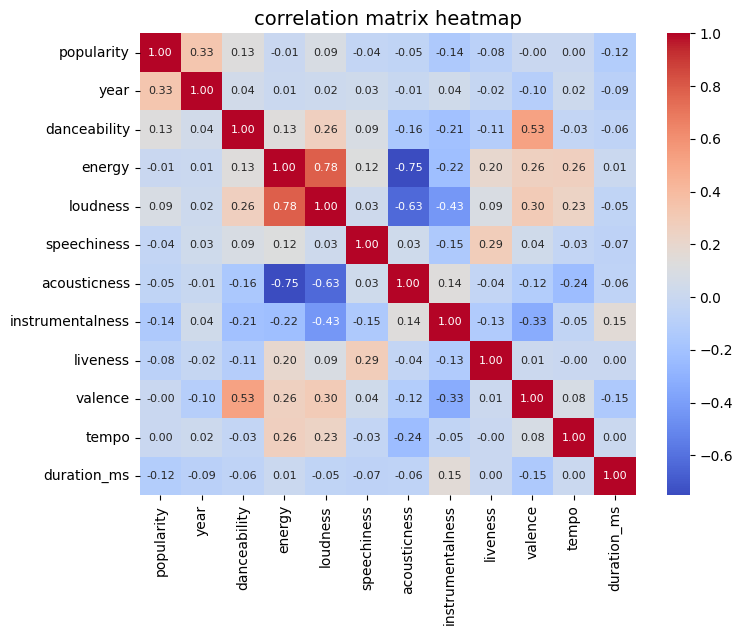

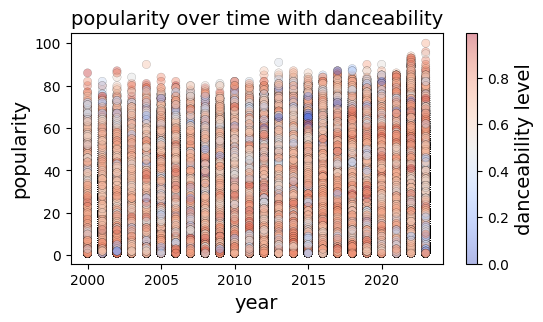

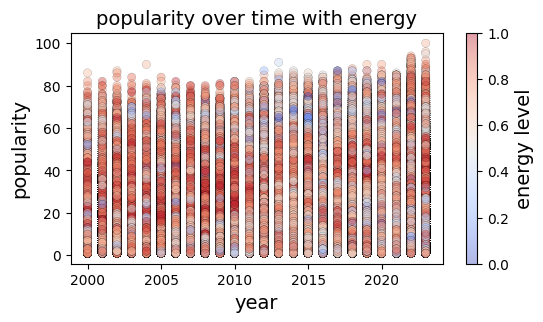

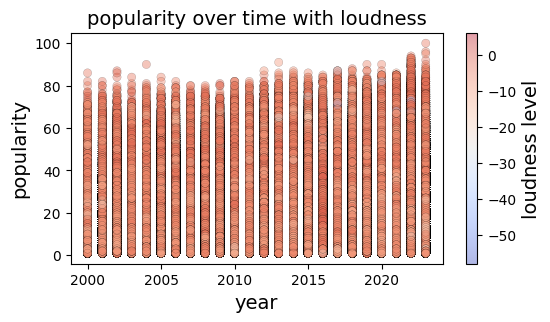

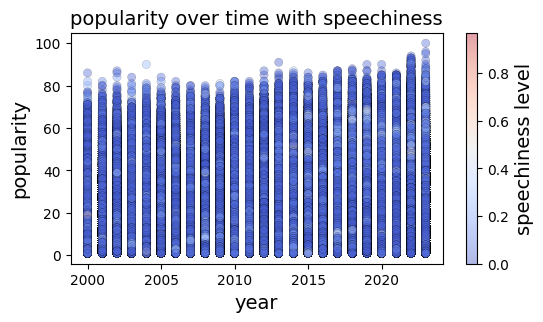

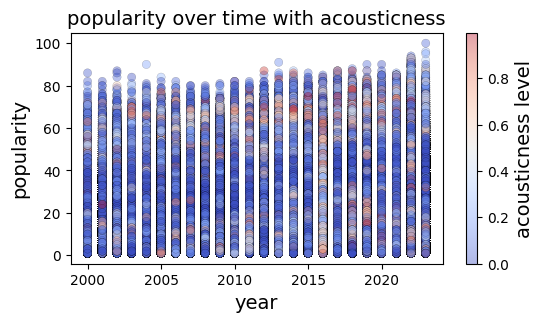

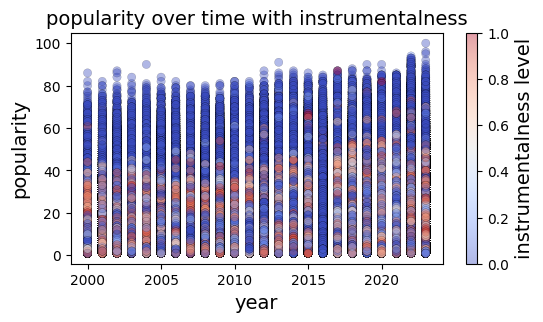

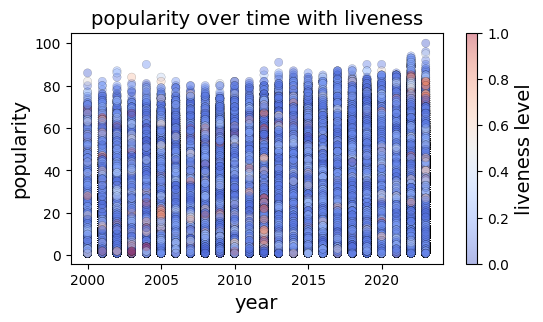

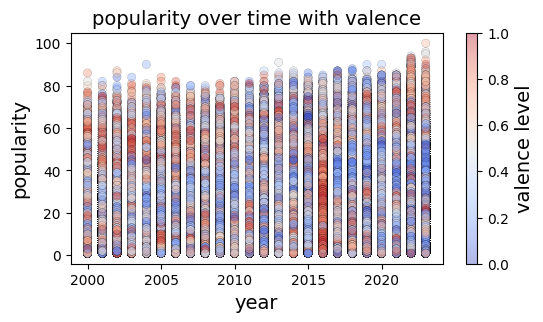

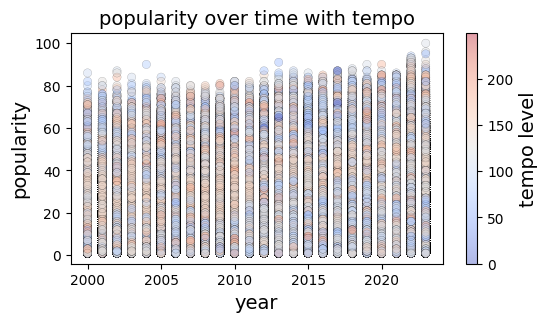

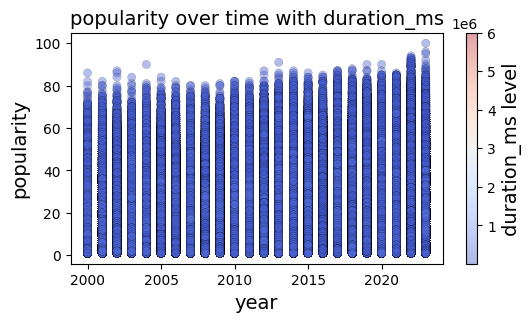

In [ ]:
# 1. perform data visualisation
## b. scatter plots & correlation matrix
correlation_matrix = numerical_features.corr() #correlation matrix
correlation_with_popularity = correlation_matrix["popularity"].sort_values(ascending=False)
print("correlation with popularity")
print(correlation_with_popularity)

plt.figure(figsize=(8, 6)) #correlation matrix heatmap
plt.rc('font', size=8)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("correlation matrix heatmap")
plt.show()

for feature in ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']: #scatterplots w.r.t. popularity and year
  plt.figure(figsize=(6, 3))
  scatter = plt.scatter(numerical_features["year"], numerical_features["popularity"], c=numerical_features[feature], cmap="coolwarm", alpha=0.4, edgecolors="k", linewidth=0.2)
  cbar = plt.colorbar(scatter)
  cbar.set_label(f"{feature} level")
  plt.xlabel("year")
  plt.ylabel("popularity")
  plt.title(f"popularity over time with {feature}")
  plt.show()

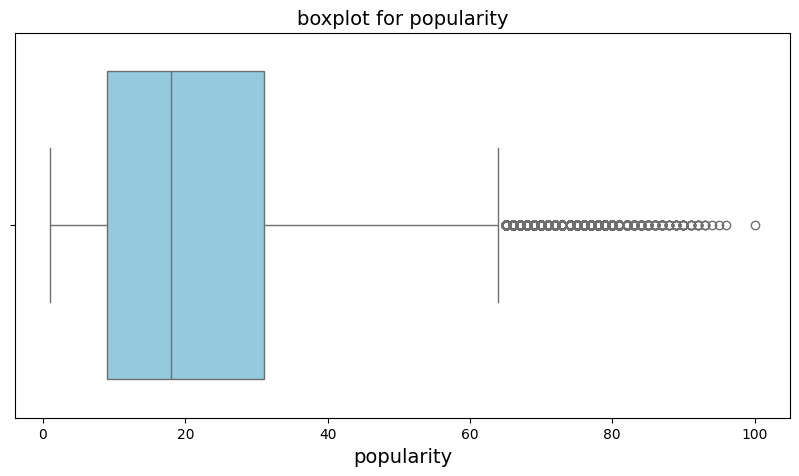

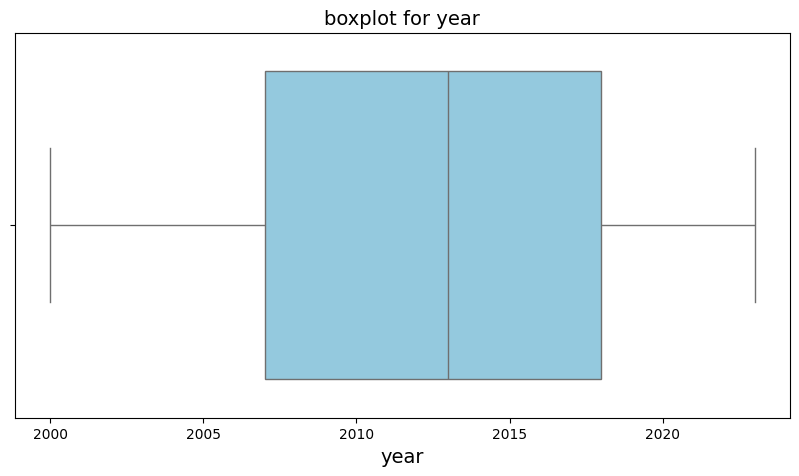

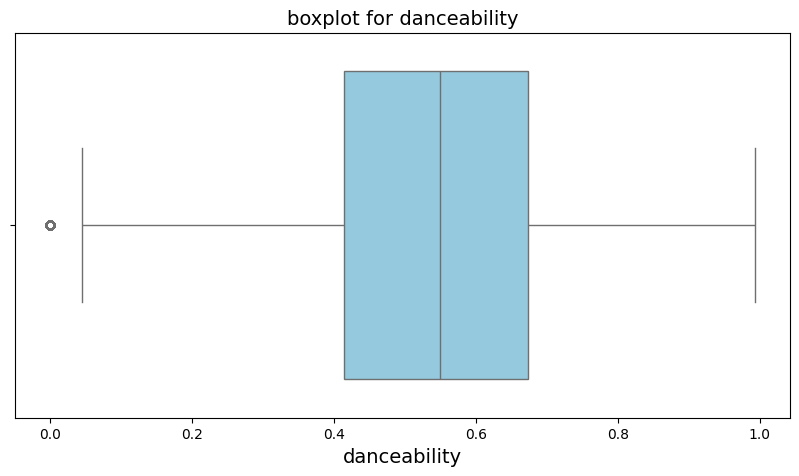

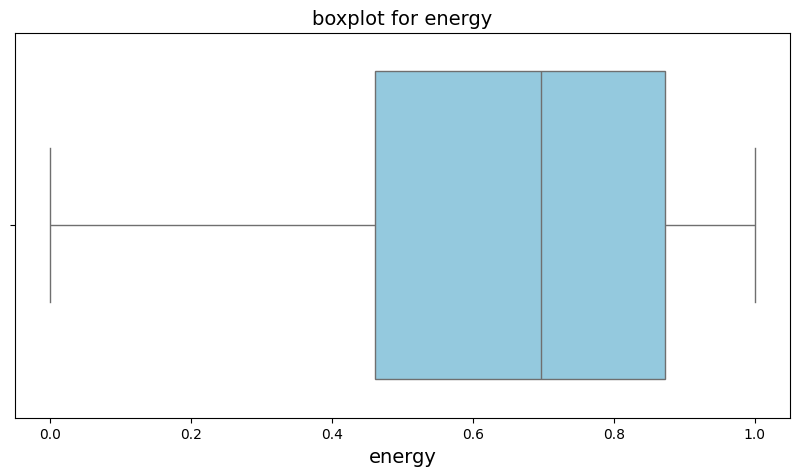

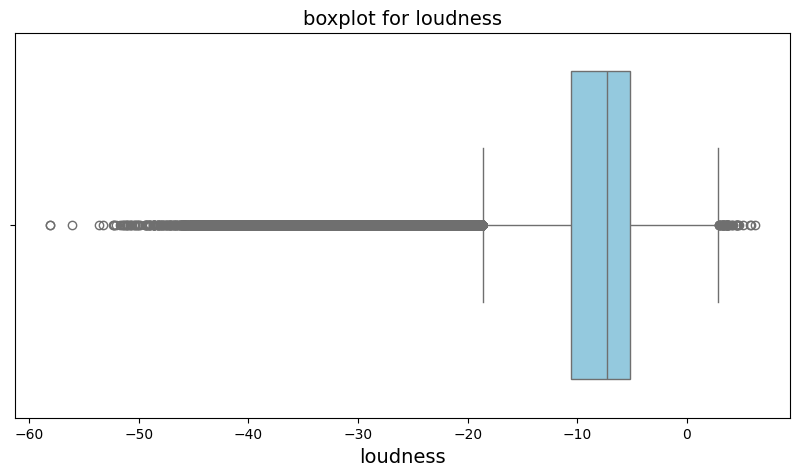

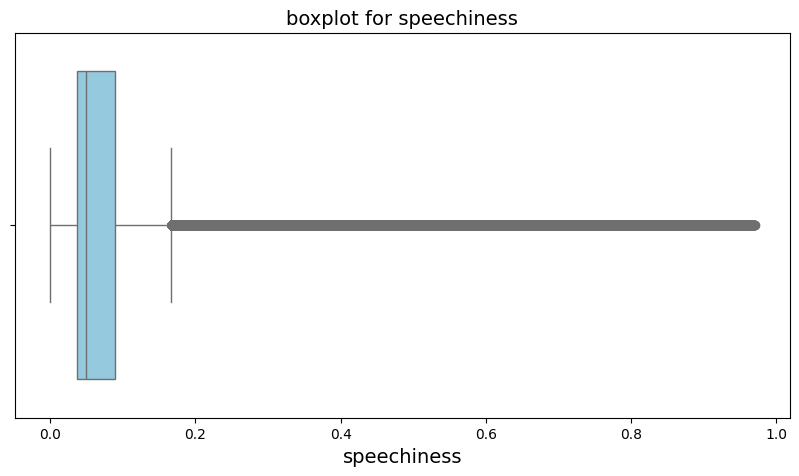

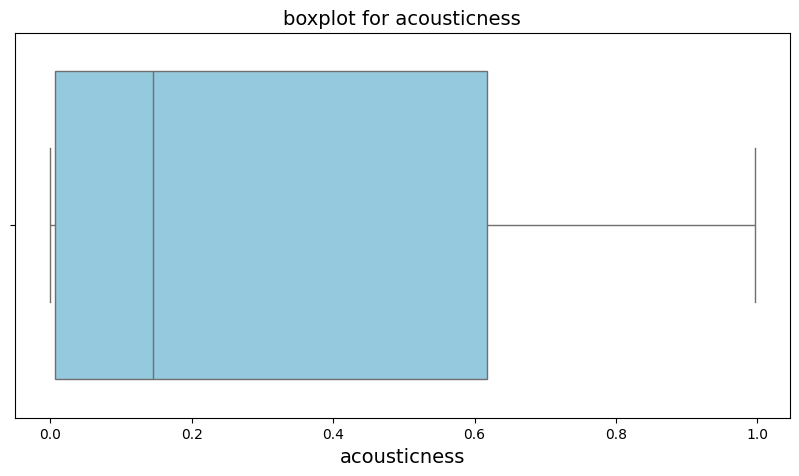

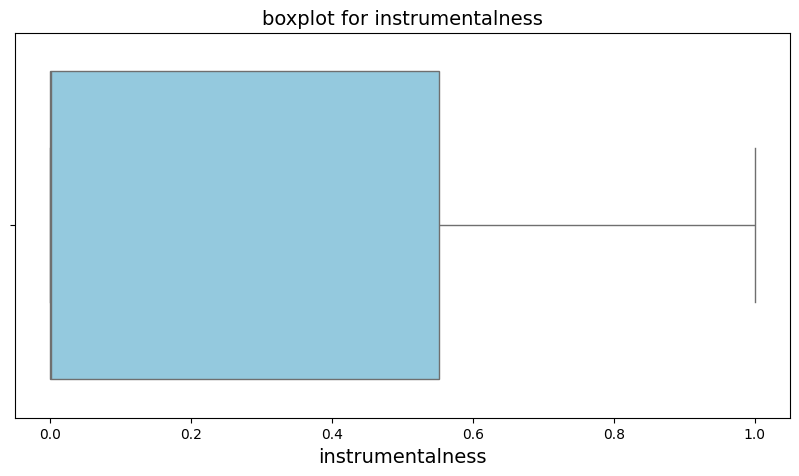

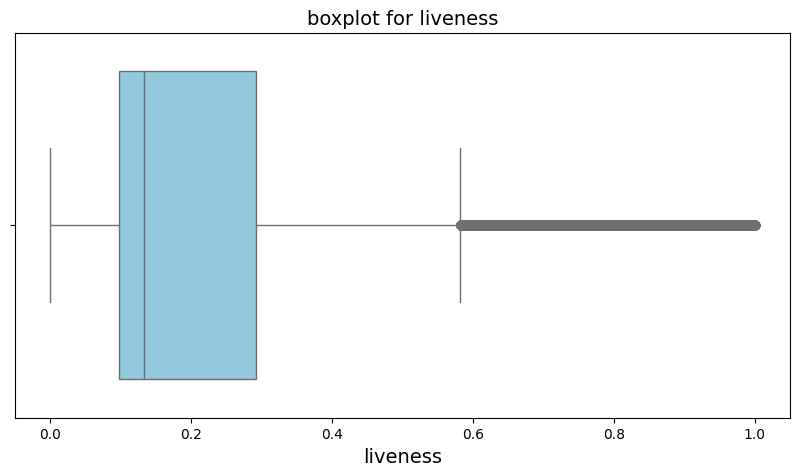

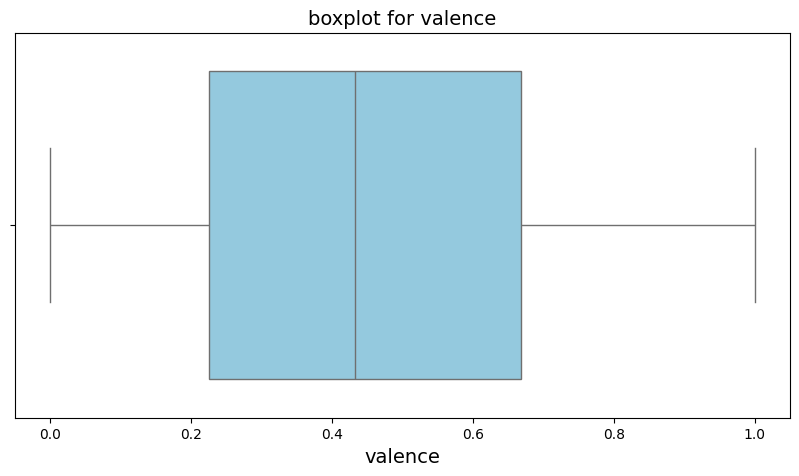

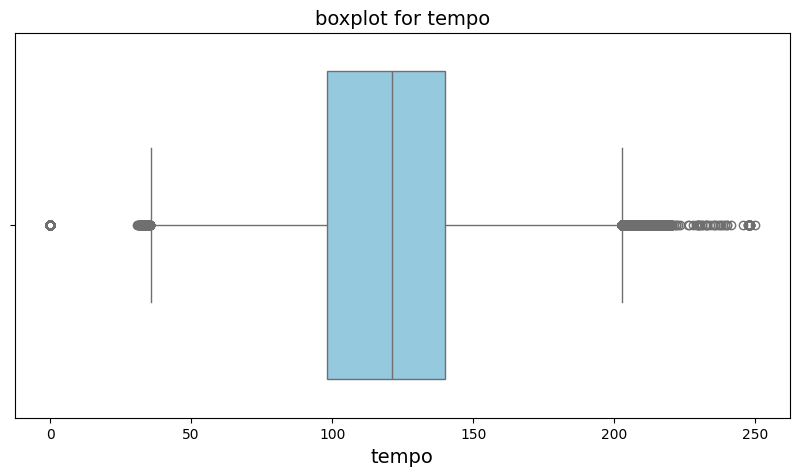

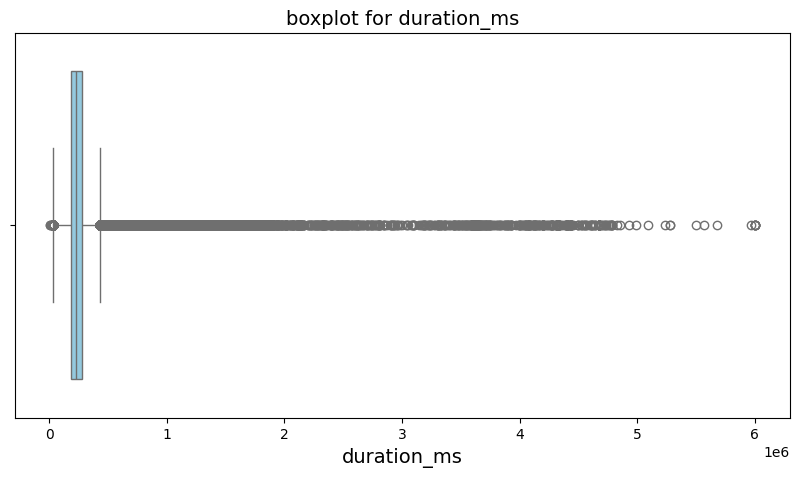

In [ ]:
# 1. perform data visualisation
## c. boxplots to identify outliers
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=numerical_features[feature], color='skyblue')
    plt.title(f"boxplot for {feature}")
    plt.show()

In [ ]:
# 2. identify missing values and handle them appropriately
missing_values = dataset.isnull().sum()
print("missing values in the entire dataset:")
print(missing_values)

missing values in the entire dataset:
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64


In [ ]:
# 3. identify outliers as well
Q1 = numerical_features["popularity"].quantile(0.25)
Q3 = numerical_features["popularity"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
outliers = numerical_features[(numerical_features["popularity"] < lower_bound) | (numerical_features["popularity"] > upper_bound)]
print("outliers in popularity:\n", outliers)

outliers in popularity:
          popularity  year  danceability  energy  loudness  speechiness  \
0                68  2012         0.483   0.303   -10.058       0.0429   
1770             77  2012         0.471   0.924    -3.906       0.0586   
1771             71  2012         0.285   0.613    -6.412       0.0421   
1772             68  2012         0.442   0.939    -4.180       0.0941   
1773             71  2012         0.531   0.638    -5.145       0.0809   
...             ...   ...           ...     ...       ...          ...   
1147679          65  2011         0.846   0.634    -7.753       0.0432   
1150686          81  2011         0.733   0.710    -5.849       0.0292   
1150687          66  2011         0.436   0.893    -4.180       0.0556   
1150689          65  2011         0.632   0.908    -3.511       0.0458   
1150771          65  2011         0.788   0.916    -5.152       0.1210   

         acousticness  instrumentalness  liveness  valence    tempo  \
0            0.

In [ ]:
# 4. identify and discuss important features
print('important features:')
print('1. year:\nmoderate positive correlation with popularity')
print('more recent songs tend to be more popular')
print('2. danceability: weak positive correlation with popularity')
print('danceable songs might be more engaging, but other features may play bigger roles.')
print('3. loudness: weak positive correlation')
print('loudness is often associated with energetic music, but does not determine popularity alone')

important features:
1. year:
moderate positive correlation with popularity
more recent songs tend to be more popular
2. danceability: weak positive correlation with popularity
danceable songs might be more engaging, but other features may play bigger roles.
3. loudness: weak positive correlation
loudness is often associated with energetic music, but does not determine popularity alone


# Task 3: Data Preprocessing & Feature Engineering

In [ ]:
# 1. handle missing values
missing_values = dataset.isnull().sum()
print("missing values in the entire dataset:")
print(missing_values)

missing values in the entire dataset:
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64


In [21]:
# 2. convert categorical features to numerical (one-hot encoding or label encoding)
print("categorical features: genre, key, mode (already binary), time_signature")
dataset = dataset.reset_index(drop=True) #concatenation can introduce missing values if the indices of the encoded df (key, time_signature, genre) do not match the original dataset

cat_encoder = OneHotEncoder(sparse_output=False) #one-hot encode 'key'
key_1hot = cat_encoder.fit_transform(dataset[['key']])
key = pd.DataFrame(key_1hot, columns=cat_encoder.get_feature_names_out(['key']))
dataset = pd.concat([dataset, key], axis=1).drop(columns=['key'])

cat_encoder = OneHotEncoder(sparse_output=False) #one-hot encode 'time_signature'
time_signature_1hot = cat_encoder.fit_transform(dataset[['time_signature']])
time_signature = pd.DataFrame(time_signature_1hot, columns=cat_encoder.get_feature_names_out(['time_signature']))
dataset = pd.concat([dataset, time_signature], axis=1).drop(columns=['time_signature'])

cat_encoder = OneHotEncoder(sparse_output=False) #one-hot encode 'genre'
genre_1hot = cat_encoder.fit_transform(dataset[['genre']])
genre = pd.DataFrame(genre_1hot, columns=cat_encoder.get_feature_names_out(['genre']))
dataset = pd.concat([dataset, genre], axis=1).drop(columns=['genre'])

categorical features: genre, key, mode (already binary), time_signature


In [22]:
# 3. scale numerical features
print('standard scaler will be used for: danceability, tempo')
print('minmax scaler will be used for: energy, year, loudness, speechiness, acousticness, instrumentalness, liveness, valence, duration_ms')

standard_pipeline = Pipeline([
    ("standardize", StandardScaler())
])
minmax_pipeline = Pipeline([
    ("minmax", MinMaxScaler())
])
numerical_preprocessing = ColumnTransformer([
    ("standardize", standard_pipeline, ['danceability', 'tempo']),
    ("minmax", minmax_pipeline, ['energy', 'year', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms'])
], remainder='passthrough') #prevents other columns from being dropped

# 4. create new features if applicable. not applicable lol

standard scaler will be used for: danceability, tempo
minmax scaler will be used for: energy, year, loudness, speechiness, acousticness, instrumentalness, liveness, valence, duration_ms


# Task 4: Model Selection & Training

In [23]:
# 1. split data into training (80%) and test (20%) [stratified sampling]
dataset["popularity_cat"] = pd.qcut(dataset["popularity"], q=3, labels=["low", "medium", "high"]) #creates equal-sized groups instead of using fixed bin ranges like 0, 33, 66, 100
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #increase chances of getting more high samples since they're less
for train_index, test_index in splitter.split(dataset, dataset["popularity_cat"]):
  strat_train_set = dataset.loc[train_index]
  strat_test_set = dataset.loc[test_index]
print("distribution of popularity in the test set: ")
print(strat_test_set["popularity_cat"].value_counts() / len(strat_test_set))
X_train = strat_train_set.drop(columns=['popularity', 'popularity_cat'])
y_train = strat_train_set['popularity']
X_test = strat_test_set.drop(columns=['popularity', 'popularity_cat'])
y_test = strat_test_set['popularity']

distribution of popularity in the test set: 
popularity_cat
low       0.350513
high      0.332947
medium    0.316540
Name: count, dtype: float64


In [24]:
# 2. train and compare at least 3 different models
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# gb_model = GradientBoostingRegressor()
# gb_model.fit(X_train, y_train)
# y_pred_gb = gb_model.predict(X_test)

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("*Note: Due to RAM limitations on both my laptop and Colab, I am only able to train two models instead of three at one time. So the code for the third model is commented out. Thank you for your understanding!")

*Note: Due to RAM limitations on both my laptop and Colab, I am only able to train two models instead of three at one time. So the code for the third model is commented out. Thank you for your understanding!


In [25]:
# 3. evaluate models using rmse, r² score
print("linear regressor:")
print("rmse: ", mt.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("r2 score: ", r2_score(y_test, y_pred_lr))

# print("\ngradient boosting:")
# print("rmse: ", mt.sqrt(mean_squared_error(y_test, y_pred_gb)))
# print("r2 score: ", r2_score(y_test, y_pred_gb))

print("\ndecision tree regressor:")
print("rmse: ", mt.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("r2 score: ", r2_score(y_test, y_pred_dt))

linear regressor:
rmse:  10.58850243547569
r2 score:  0.5155019560714611

decision tree regressor:
rmse:  13.224098298829436
r2 score:  0.24429014814325956


In [26]:
# 4. perform cross-validation (cross_val_score) for better model evaluation
X = dataset.drop(columns=['popularity', 'popularity_cat'])
y = dataset['popularity']
print("linear regression:")
lr_rmses = -cross_val_score(lr_model, X, y, cv=10, scoring="neg_root_mean_squared_error")
print(pd.Series(lr_rmses).describe())

# print("\ngradient boosting regression:")
# gb_rmses = -cross_val_score(gb_model, X, y, cv=10, scoring="neg_root_mean_squared_error")
# print(pd.Series(gb_rmses).describe())

print("\ndecision tree regression:")
dt_rmses = -cross_val_score(dt_model, X, y, cv=10, scoring="neg_root_mean_squared_error")
print(pd.Series(dt_rmses).describe())

linear regression:
count    10.000000
mean     10.718864
std       0.924690
min       9.907109
25%      10.180516
50%      10.411583
75%      10.844982
max      13.052810
dtype: float64

decision tree regression:
count    10.000000
mean     14.017569
std       0.755362
min      13.499520
25%      13.633356
50%      13.706564
75%      14.156498
max      16.009782
dtype: float64


# Task 5: Hyperparameter Tuning

In [27]:
# 1. use GridSearchCV or RandomizedSearchCV to optimise hyperparameters
full_pipeline = Pipeline([
    ("numerical_preprocessing", numerical_preprocessing),
    ("model", LinearRegression()) #linear regression is a placeholder for now
])
param_grid = [
    {
        'model': [LinearRegression()], #linear regression hyperparameters
        'numerical_preprocessing__standardize__standardize__with_mean': [True, False],
        'model__fit_intercept': [True, False]
    },
    {
        'model': [DecisionTreeRegressor(random_state=42)], #decision tree hyperparameters
        'model__max_depth': [5, 10, 15], #maximum depth of trees
        'model__min_samples_split': [2, 5, 10]
    } #,
    # {
    #     'model': [GradientBoostingRegressor(random_state=42)], #gradient boosting hyperparameters
    #     'model__n_estimators': [50, 100, 200], #number of boosting stages
    #     'model__learning_rate': [0.01, 0.1, 0.2], #step size shrinkage
    #     'model__max_depth': [3, 5, 7] #maximum depth of trees
    # }
]
grid_search = GridSearchCV(
    full_pipeline, #pipeline to optimize
    param_grid, #parameter grid to search
    cv=3, #3-fold cross-validation
    scoring='neg_root_mean_squared_error', #use negative rmse for evaluation
    n_jobs=-1, #use all available cpu cores
)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('numerical_preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardize',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'tempo']),
                                                                        ('minmax',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['energy',
                                                                          'year',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          '...
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [LinearRegression()],
                          'model__fit_intercept': [True, False],
                          'numerical_preprocessing__standardize__standardize__with_mean': [True,
                                                                                           False]},
                         {'model': [DecisionTreeRegressor(random_state=42)],
                          'model__max_depth': [5, 10, 15],
                          'model__min_samples_split': [2, 5, 10]}],
             scoring='neg_root_mean_squared_error')

In [28]:
# 2. compare the best-tuned model with previous models
best_model = grid_search.best_estimator_ #gets best model
y_pred_best = best_model.predict(X_test) #evaluate the best model on the test set
rmse_best = mt.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("best model:")
print("best model rmse:", rmse_best)
print("best model r² Score:", r2_best)

print("\nlinear regression:")
print("rmse: ", mt.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("r2 score: ", r2_score(y_test, y_pred_lr))

# print("\ngradient boosting regression:")
# print("rmse: ", mt.sqrt(mean_squared_error(y_test, y_pred_lr)))
# print("r2 score: ", r2_score(y_test, y_pred_lr))

print("\ndecision tree regression:")
print("rmse: ", mt.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("r2 score: ", r2_score(y_test, y_pred_dt))

best model:
best model rmse: 10.588502435475748
best model r² Score: 0.5155019560714558

linear regression:
rmse:  10.58850243547569
r2 score:  0.5155019560714611

decision tree regression:
rmse:  13.224098298829436
r2 score:  0.24429014814325956


In [29]:
# 3. report the best hyperparameter values
print("best hyperparameters: ", grid_search.best_params_)

best hyperparameters:  {'model': LinearRegression(), 'model__fit_intercept': True, 'numerical_preprocessing__standardize__standardize__with_mean': True}


# Task 6: Final Model Evaluation

In [30]:
# 1. Evaluate the best model on the test dataset
y_pred_best = best_model.predict(X_test)

best model rmse: 10.568833801130708
best model r² score: 0.5144871928262705


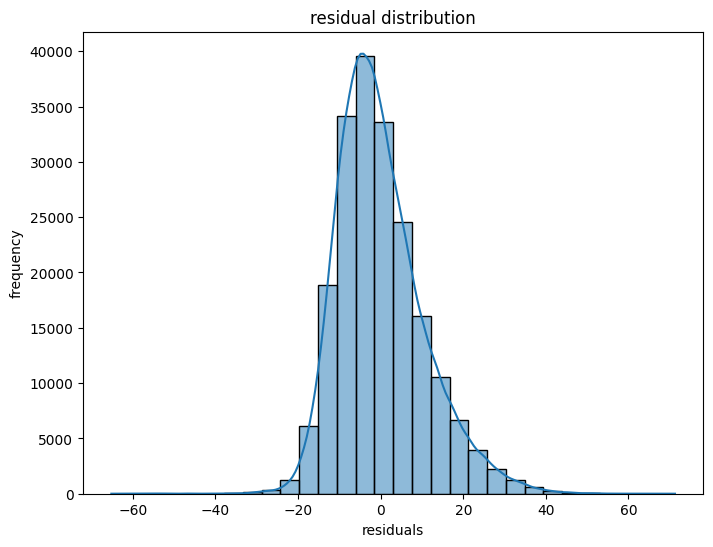

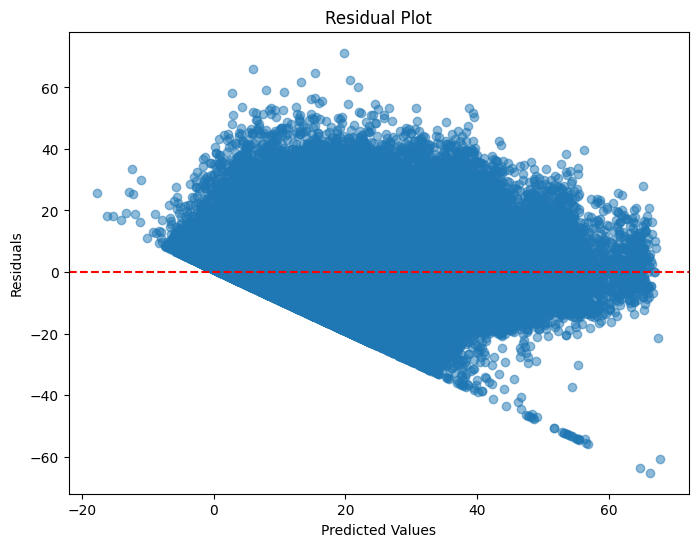

In [ ]:
# 2. Generate final metrics and visualisations (residual plots for regression)
rmse_best = mt.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)
print("best model rmse:", rmse_best)
print("best model r² score:", r2_best)

residuals = y_test - y_pred_best

plt.figure(figsize=(8, 6)) #residual distribution plot
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("residuals")
plt.ylabel("frequency")
plt.title("residual distribution")
plt.show()

plt.figure(figsize=(8, 6)) #residuals vs. predicted values plot
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.title("residual plot")
plt.show()

# Task 7: Report & Presentation

In [ ]:
# 1. submit a well-structured report
## a. dataset selection & EDA summary
## b. preprocessing steps
## c. model selection and training
## d. fine-tuning process
## e. final conclusions and best model
print("done")

# 2. prepare a 5-minute video presentation explaining key findings

# Task 8: Comparing Holdout Validation, Cross-Validation, and K-Fold Validation

In [ ]:
'''
1.
Dataset Selection: Choose a dataset relevant to your field of study or work with a provided dataset.
2.
Implement Validation Techniques:
a.
Perform Holdout Validation (e.g., 80-20 or 70-30 split).
b.
Perform K-Fold Cross-Validation (e.g., k=5 or k=10).
c.
Perform Leave-One-Out Cross-Validation (LOOCV) as an extreme case.
3.
Compare Performance Metrics: Evaluate models using appropriate metrics (e.g., accuracy, RMSE, F1-score).
4.
Discuss Bias-Variance Tradeoff: Explain how each method impacts bias and variance in model performance.
5.
Final Recommendation: Based on your results, suggest the most suitable validation method for your dataset and justify your choice.
'''

# Task 9: Stratified Sampling

In [ ]:
print('done')

# Task 10: Handling Text and Categorical Attributes

In [ ]:
'''
Handling Categorical Attributes:
•
Explain how you processed categorical attributes in your dataset.
•
Did you use label encoding, one-hot encoding, or any other technique? Justify your choice.
•
If there were missing categorical values, describe how you handled them.
Handling Text Attributes:
•
Describe the steps you took to preprocess text data, such as cleaning, tokenization, or stemming.
•
Explain how you converted text into a numerical format (e.g., Bag-of-Words, TF-IDF, or word embeddings).
•
Discuss any challenges you faced and how you addressed them.
'''